# Titanic Dataset Analysis

In [1]:
import pandas as pd
import matplotlib
import seaborn

filename = 'titanic_data.csv'
titanic_df = pd.read_csv(filename)

## Check out the data

In [3]:
# Get general statistics
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The describe output is really only appropriate for the Age and Fare columns. The other columns appear to be numeric but are not. We can see already that there is missing Age data.

In [4]:
# See where the missing values are
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In addition to the 177 missing Age variables, there are also nulls in the Cabin and Embarked columns.

## Effect of sex and passenger class on survival

In [6]:
survived_counts = titanic_df.groupby('Survived')['Survived'].count()
survived_counts

Survived
0    549
1    342
Name: Survived, dtype: int64

In [5]:
survived_counts / survived_counts.sum()

Survived
0    0.616162
1    0.383838
Name: Survived, dtype: float64

Of the 891 Passengers (in this dataset), 342 survived and 549 did not survive. In percentages, 38% survived and 62% did not.

### Survival by sex

In [9]:
pd.crosstab(titanic_df['Sex'], titanic_df['Survived'])

Survived,0,1
Sex,,
female,81,233
male,468,109


In [8]:
# margins=True adds row and column totals
pd.crosstab(titanic_df['Sex'], titanic_df['Survived'], margins=True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


In [7]:
# takes a series where the last element is the total and returns the the elments as a percentage
def percConvert(series):
    return series/float(series[-1])

pd.crosstab(titanic_df['Sex'], titanic_df['Survived'], margins=True).apply(percConvert, axis=1)

Survived,0,1,All
Sex,,,
female,0.257962,0.742038,1.0
male,0.811092,0.188908,1.0
All,0.616162,0.383838,1.0


Women had a much higher survival rate than men, 74% for women versus 19% for men.

### Survival by sex and passenger class

In [10]:
pd.crosstab([titanic_df['Pclass'],titanic_df['Sex']], titanic_df['Survived'])

Survived         0   1
Pclass Sex            
1      female    3  91
       male     77  45
2      female    6  70
       male     91  17
3      female   72  72
       male    300  47

In [12]:
pd.crosstab([titanic_df['Pclass'],titanic_df['Sex']], titanic_df['Survived'], margins=True).apply(percConvert, axis=1)

Survived              0         1  All
Pclass Sex                            
1      female  0.031915  0.968085  1.0
       male    0.631148  0.368852  1.0
2      female  0.078947  0.921053  1.0
       male    0.842593  0.157407  1.0
3      female  0.500000  0.500000  1.0
       male    0.864553  0.135447  1.0
All            0.616162  0.383838  1.0

Adding the passenger class to the cross tabulation, we see that survival rate of women in third class had a much lower survival rate than the other two classes, 50% compared to 96% and 92%.

For men, the survival rate was highest in first class, 37%, and less than half that in second and third class.

## Effect of age on survival

In [13]:
titanic_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

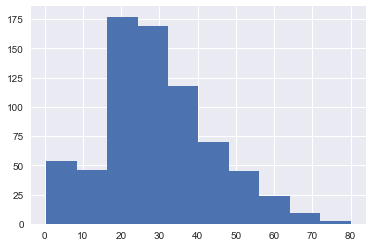

In [16]:
%matplotlib inline
titanic_df['Age'].hist()

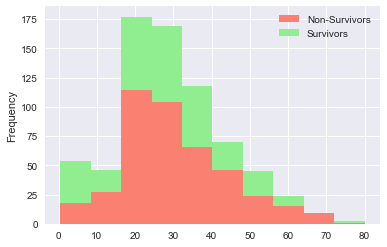

In [26]:
non_survivors = titanic_df.groupby('Survived').get_group(0)
survivors = titanic_df.groupby('Survived').get_group(1)

colors = ['salmon', 'lightgreen']
pd.DataFrame({'Non-Survivors': non_survivors.Age,
              'Survivors': survivors.Age}).plot.hist(stacked=True, color=colors)

### Address Nulls

In [30]:
def sum_nulls(series):
    return series.isnull().sum()

nulls_by_survived = titanic_df.groupby('Survived')['Age'].apply(sum_nulls)
nulls_by_survived

Survived
0    125
1     52
Name: Age, dtype: int64

In [29]:
nulls_by_survived / nulls_by_survived.sum()

Survived
0    0.706215
1    0.293785
Name: Age, dtype: float64

70% of the missing ages were for those who did not survive. This makes sense since it's likely that the ages may not have been recorded until after the incident.

In [31]:
titanic_df.groupby('Survived')['Age'].mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

The mean age for survivors is 28 and the mean age for non-survivors is 31. We can use these means to fill in missing values depending on the Survived value.

In [ ]:
# using transform instead of apply with groupby preserves the row order
# this is important if you want to save the results back to the original dataframe
age_filled = titanic_df.groupby('Survived')['Age'].transform(lambda x: x.fillna(x.mean()))

### Binning and cross-tabulation

In [36]:
age_filled_cat = pd.cut(age_filled, bins=[0, 5, 13, 18, 35, 60, 80])
pd.crosstab(age_filled_cat, titanic_df['Survived'], margins=True).apply(percConvert, axis=1)

Survived,0,1,All
Age,,,
"(0, 5]",0.295455,0.704545,1.0
"(5, 13]",0.592593,0.407407,1.0
"(13, 18]",0.588235,0.411765,1.0
"(18, 35]",0.646729,0.353271,1.0
"(35, 60]",0.600000,0.400000,1.0
"(60, 80]",0.772727,0.227273,1.0
All,0.616162,0.383838,1.0


The ages were binned using handpicked boundaries to represent life stages. The results show that there are really only three groupings needed: 0-5, 5-60, and 60-80.

For infants and young children (Ages 0-5), the survival rate was higher than average, 70%. For the elderly (Ages 60-80), it was lower, 23%. All the other groups were about average.

In [37]:
pd.crosstab(age_filled_cat, titanic_df['Survived'], margins=True)

Survived,0,1,All
Age,,,
"(0, 5]",13,31,44
"(5, 13]",16,11,27
"(13, 18]",40,28,68
"(18, 35]",346,189,535
"(35, 60]",117,78,195
"(60, 80]",17,5,22
All,549,342,891


It's also useful to see the raw numbers. There were 44 individuals in ages 0-5 and 22 in 60-80.